In [2]:
# ! pip3 install pandas
import pandas as pd
import numpy as np
from datacleaning import clean_data, create_sample
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier


In [3]:
sample = create_sample(-1)
sample = clean_data(sample)


18800
length of sample after removing duplicates:  12254
length of sample after removing empty reviews 11262


### Processing Step 1

Linear Regression can be used to approximate a the scores in our dataset.

Accuracy:  0.9276520195295161


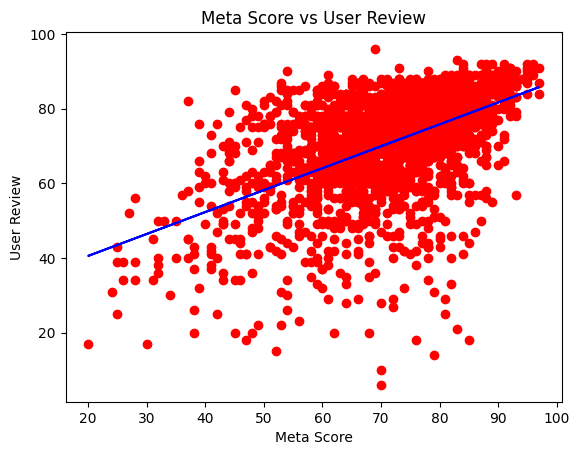

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures



def linear_reg(df):
    df['user_review'] = pd.to_numeric(df['user_review'], errors='coerce')
    df= df.dropna(subset=['user_review']) 

    x = df['meta_score']
    y = df['user_review'] * 10
    
    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2, random_state = 0)

    model = LinearRegression()
    model.fit(xTrain.values.reshape(-1, 1), yTrain)

    yPred = model.predict(xTest.values.reshape(-1, 1))

    correct_predictions = np.sum(np.abs(yPred - yTest) <= 20)
    total_predictions = len(yTest)
    accuracy = correct_predictions / total_predictions
    print('Accuracy: ', accuracy)

    plt.scatter(xTest, yTest, color = 'red')
    plt.plot(xTest, yPred, color = 'blue')
    plt.title('Meta Score vs User Review')
    plt.xlabel('Meta Score')
    plt.ylabel('User Review')

    return
    
linear_reg(sample)    

### Processing Step 2

We can use Naive Bayes to state a metric that says any user_review score above 50 is a "good" game and then try to predict whether a game will be good based on words used in the game summary. We are essentially looking for the model to output "good" or "bad" and them compare this to the user review to assess accuracy.

Accuracy: 0.8983577452285841


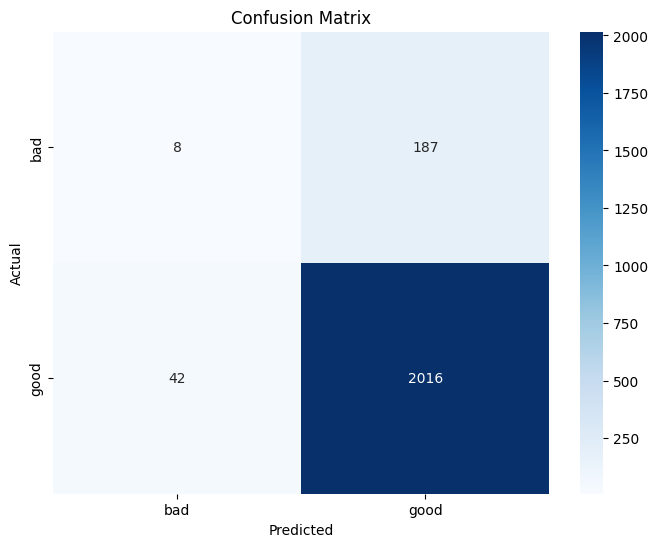

In [5]:
def naive_bayes(df):
    df['label'] = df['user_review'].apply(lambda x: 'good' if x > 5 else 'bad')
    v = CountVectorizer()

    x = v.fit_transform(df['summary'])
    y = df['label']

    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2, random_state = 0)

    model = MultinomialNB()
    model.fit(xTrain, yTrain)

    yPred = model.predict(xTest)

    print("Accuracy:", accuracy_score(yTest, yPred))

    cm = confusion_matrix(yTest, yPred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

   
    return

naive_bayes(sample)

### Processing Step 3: KNN

In [6]:
# KNN
import numpy as np

sample['user_review'] = sample['user_review'].apply(lambda x: int(float(x)* 10))

class KNNClassifier:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = []
        for sample in X_test:
            distances = []
            for train_sample, label in zip(self.X_train, self.y_train):
                # print(type(sample), train_sample)
                distance = np.linalg.norm(np.array(sample) - np.array(train_sample))
                distances.append((distance, label))
            distances.sort(key=lambda x: x[0])
            k_nearest = distances[:self.k]
            k_nearest_labels = [label for _, label in k_nearest]
            prediction = max(set(k_nearest_labels), key=k_nearest_labels.count)
            predictions.append(prediction)
        return predictions

if __name__ == "__main__":

    # print(sample)
    X_train = list(zip(*map(sample.get, ['meta_score_normalized', 'user_review_normalized'])))
    y_train = list(sample["genre"])

    leng = len(X_train)
    training = int(leng * 0.4)

    knn = KNNClassifier(k=25)
    knn.fit(X_train[:training], y_train[:training])
    predictions = knn.predict(X_train[training:])

    hits = 0
    total = 0
    actual = y_train[training:]
    print(len(predictions), len(actual))
    for i,v in enumerate(predictions):
      if (v == actual[i]):
        hits += 1
      total += 1
    print("Accuracy:", hits/total*100)

6758 6758
Accuracy: 59.307487422314296


### Processing Step 4: K-Means

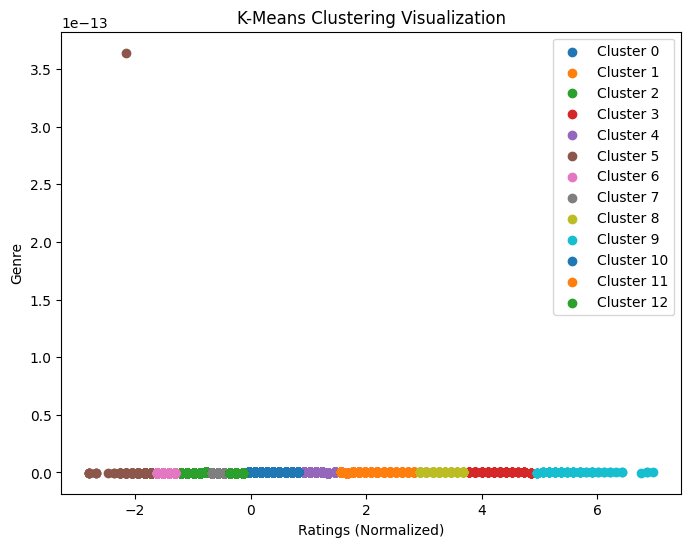

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

X_train = np.array(list(zip(*map(sample.get, ['user_review_normalized', 'user_review_normalized']))))
y_train = list(sample["genre"])
training = int(leng * 0.09)
labels = { v:k for k,v in enumerate(set(sample["genre"]))}
kmeans = KMeans(n_clusters=len(labels.keys()))
kmeans.fit(X_train)
cluster_labels = kmeans.labels_

# from the pca vis documentation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
plt.figure(figsize=(8, 6))
for i in range(len(labels.keys())):
    plt.scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], label=f'Cluster {i}')

plt.title('K-Means Clustering Visualization')
plt.xlabel('Ratings (Normalized)')
plt.ylabel('Genre')
plt.legend()
plt.show()

### Processing Step 5: Random Forest Classifier

Accuracy: 0.03445213993961996


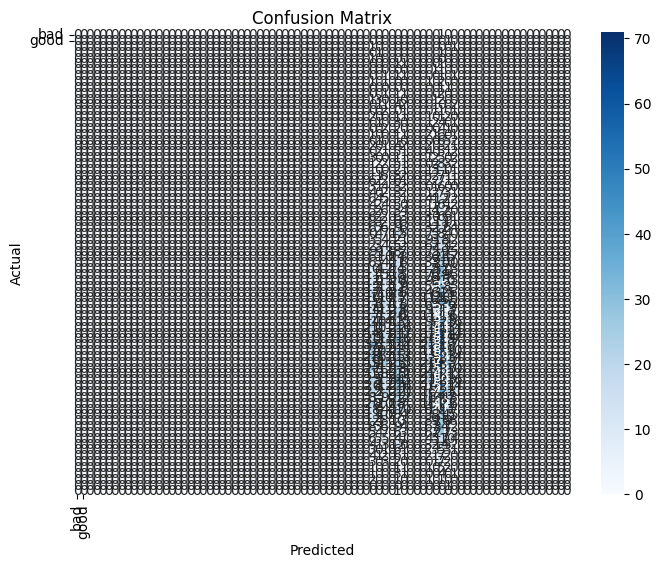

In [7]:
def month_name_to_number(month_name):
    months = {
        'January': 1,
        'February': 2,
        'March': 3,
        'April': 4,
        'May': 5,
        'June': 6,
        'July': 7,
        'August': 8,
        'September': 9,
        'October': 10,
        'November': 11,
        'December': 12
    }
    return months[month_name]

def random_forest_classifier(df):
    # Drop rows with missing values in relevant columns
    df_cleaned = df.dropna(subset=['month', 'meta_score'])
    
    df['label'] = df['meta_score'].apply(lambda x: 'good' if x > 50 else 'bad')

    # Convert month names to numbers
    df_cleaned['month'] = df_cleaned['month'].apply(month_name_to_number)

    # Define feature and target variables
    feature = ['month']
    target = 'meta_score'

    # Select features and target variable
    X = df_cleaned[feature]
    y = df_cleaned[target]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

    # Create and train the model
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Make predictions
    predictions = rf_classifier.predict(X_test)

    # Evaluate accuracy
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy:", accuracy)
    
    cm = confusion_matrix(y_test, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

random_forest_classifier(sample)


### Processing Step 6: Gradient Boosting Classifier

Accuracy: 0.0326762564375777


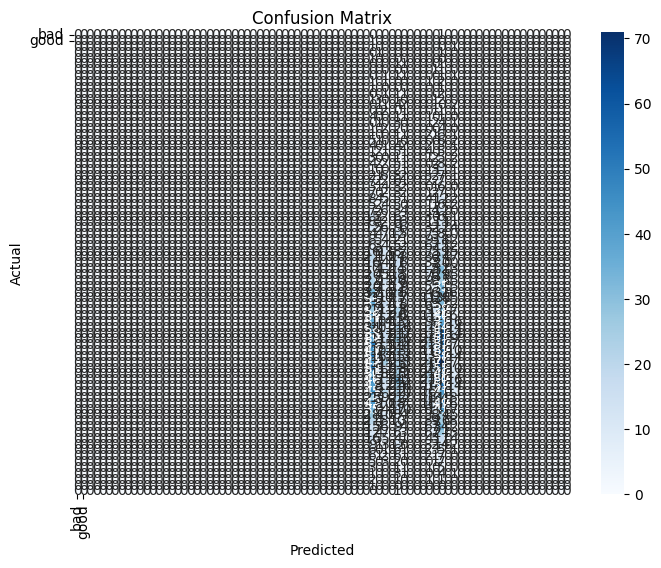

In [8]:
def gradient_boosting_classifier(df):
    # Drop rows with missing values in relevant columns
    df_cleaned = df.dropna(subset=['month', 'meta_score'])

    # Convert month names to numbers
    df_cleaned['month'] = df_cleaned['month'].apply(month_name_to_number)
    
    df['label'] = df['user_review'].apply(lambda x: 'good' if x > 50 else 'bad')

    # Define feature and target variables
    feature = ['month']
    target = 'meta_score'

    # Select features and target variable
    X = df_cleaned[feature]
    y = df_cleaned[target]

    # Split data into train and test sets with a larger training set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

    # Create and train the model
    gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
    gb_classifier.fit(X_train, y_train)

    # Make predictions
    predictions = gb_classifier.predict(X_test)

    # Evaluate accuracy
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy:", accuracy)
    
    cm = confusion_matrix(y_test, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

gradient_boosting_classifier(sample)
